In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask

import numpy as np
from PIL import Image

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download data

### Municipality GeoDataFrame

(3, 6)


<AxesSubplot:>

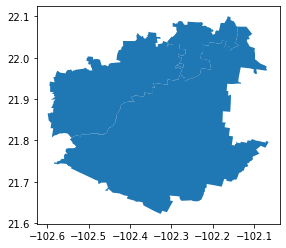

In [2]:
city = 'Aguascalientes'
query = f"SELECT * FROM metropolis.metro_list WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mun_gdf.shape)
mun_gdf.plot()

### Hex-bins GeoDataFrame

(309, 2)


<AxesSubplot:>

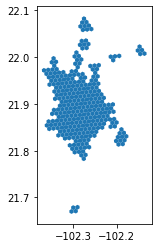

In [3]:
mpos = list(mun_gdf.CVEGEO.unique())

hex_ageb = gpd.GeoDataFrame()

schema = 'censo'
folder = 'hex_bins_pop_2020'

for m in mpos:
    query = f"SELECT hex_id_8,geometry FROM {schema}.{folder} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_ageb = pd.concat([hex_ageb, 
                          aup.gdf_from_query(query, geometry_col='geometry')], 
                         ignore_index = True, axis = 0)

print(hex_ageb.shape)
hex_ageb.plot()

## NDVI analysis

### Functions definition

In [4]:
def extract_boundary_coords(gdf):
    # Reads hex_analysis GeoDataFrame as polygon
    poly = gdf.geometry
    # Extracts coordinates from polygon as DataFrame
    coord_val = poly.bounds
    # Gets coordinates for bounding box
    n = coord_val.maxy.max()
    s = coord_val.miny.min()
    e = coord_val.maxx.max()
    w = coord_val.minx.min()
    
    return n,s,e,w

In [5]:
def poly_dictionary_from_boundary(n,s,e,w):
    # create polygon dictionary
    area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
                ]
            ],
        }
    return area_of_interest

In [6]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [7]:
def dissolve_polygon(gdf, epsg, buffer=0):
    gdf_tmp = gdf.copy()
    gdf_tmp = gdf_tmp.to_crs("EPSG:"+str(epsg))
    gdf_tmp = gdf_tmp.buffer(buffer).reset_index().rename(columns={0:'geometry'})
    dissolved_polygon = gdf_tmp.dissolve().geometry
    return dissolved_polygon

In [8]:
def raster_to_point(href, gdf):
    
    with rasterio.open(href) as ds:

        poly_mask = dissolve_polygon(gdf, ds.crs.to_epsg(), buffer=1)

        out_mask, out_transform = rasterio.mask.mask(ds, poly_mask, crop=True)
        out_meta = ds.meta
        
        ds.close()

    out_meta.update({"driver": "GTiff",
                     "height": out_mask.shape[1],
                     "width": out_mask.shape[2],
                     "transform": out_transform})

    with rasterio.open("tmp/masked.tif", "w", **out_meta) as dest:
        dest.write(out_mask)
        
        dest.close()

    with rasterio.open("tmp/masked.tif", "r", **out_meta) as src:

        val = src.read(1)
        no_data=src.nodata
        geometry = [Point(src.xy(x,y)[0],src.xy(x,y)[1]) 
                    for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        gdf = gpd.GeoDataFrame({'geometry':geometry,'data':v})
        gdf.crs = src.crs
        
        src.close()
        
    return gdf

### NDVI pipeline

In [10]:
hex_ndvi_9 = gpd.GeoDataFrame()
hex_ndvi_8 = hex_ageb.copy()
hex_ndvi_8['ndvi'] = np.nan

for hex_idx_8 in tqdm(list(hex_ageb.hex_id_8), position=0, leave=True):
    # filter hex
    hex_analysis = hex_ageb.loc[hex_ageb.hex_id_8==hex_idx_8].copy()
    # download hex with 9 resolution
    hex_indexes = str(tuple(h3.h3_to_children(hex_analysis.hex_id_8.values[0], 9)))
    schema = 'hexgrid' 
    table = 'hexgrid_9_city'
    query = f'SELECT hex_id_9,geometry FROM {schema}.{table} WHERE "hex_id_9" IN {hex_indexes}'
    hex_analysis_res9 = aup.gdf_from_query(query, geometry_col='geometry')
    
    n,s,e,w = extract_boundary_coords(hex_analysis)
    
    area_of_interest = poly_dictionary_from_boundary(n,s,e,w)
    
    # define date of interest
    time_of_interest = "2020-01-01/2021-12-31"
    
    # stablish link connection
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=area_of_interest,
        datetime=time_of_interest,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    # Check how many items were returned
    items = list(search.get_items())
    
    aup.log(f"For {hex_idx_8}, {len(items)} where returned")
    
    assets_hrefs = {}
    # create a dictionary of links for each band
    for i in items:
        assets_hrefs[i.datetime.date()] = [pc.sign(find_asset_by_band_common_name(i,"green").href)]
        assets_hrefs[i.datetime.date()].append(pc.sign(find_asset_by_band_common_name(i,"nir").href))
        
    # create a dictionary for ndvi values at resolution 9
    ndvi_dict = {}
    
    # create point data with ndvi from raster
    for k in assets_hrefs.keys():
        g = raster_to_point(assets_hrefs[k][0], hex_analysis) # green band
        nir = raster_to_point(assets_hrefs[k][1], hex_analysis) # near-infrared band
        ndvi_gdf = g.merge(nir[['data']], left_index=True, right_index=True)
        ndvi_gdf.rename(columns={'data_x':'g','data_y':'nir'}, inplace=True)
        ndvi_gdf['ndvi'] = (ndvi_gdf['nir']-ndvi_gdf['g'])/(ndvi_gdf['nir']+ndvi_gdf['g'])
        ndvi_gdf = ndvi_gdf.to_crs("EPSG:4326")

        for hex_idx in hex_analysis_res9.hex_id_9:
            hex_tmp = hex_analysis_res9.loc[hex_analysis_res9.hex_id_9==hex_idx]
            clipped_ndvi = gpd.clip(ndvi_gdf, hex_tmp)

            if hex_idx in ndvi_dict.keys():
                ndvi_dict[hex_idx].append(clipped_ndvi.ndvi.mean())
            else:
                ndvi_dict[hex_idx] = []
                ndvi_dict[hex_idx].append(clipped_ndvi.ndvi.mean())
                
    for hex_idx in ndvi_dict.keys():
        ndvi_dict[hex_idx] = sum(ndvi_dict[hex_idx]) / len(ndvi_dict[hex_idx])
                
    hex_dict = pd.DataFrame.from_dict(ndvi_dict, 
                       orient='index').reset_index().rename(
        columns={'index':'hex_id_9', 0:'ndvi'})
    
    hex_ndvi_9 = pd.concat([hex_ndvi_9, hex_dict],
                           ignore_index = True, axis = 0)
    
    hex_ndvi_8.loc[hex_ndvi_8.hex_id_8==hex_idx_8, 'ndvi'] = sum(ndvi_dict.values()) / len(ndvi_dict.values())
    

  0%|                                     | 1/309 [44:43<229:33:30, 2683.15s/it]


RasterioIOError: '/vsicurl/https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/Q/GE/2021/05/22/S2A_MSIL2A_20210522T171901_N0212_R012_T13QGE_20210523T033241.SAFE/GRANULE/L2A_T13QGE_A030897_20210522T173524/IMG_DATA/R10m/T13QGE_20210522T171901_B03_10m.tif?st=2022-08-04T17%3A04%3A16Z&se=2022-08-05T17%3A49%3A16Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-08-05T16%3A25%3A35Z&ske=2022-08-12T16%3A25%3A35Z&sks=b&skv=2021-06-08&sig=Lcb6DCrTL7TvfcuQEbLQrPErk7e%2BAQuKqkeuwjW2TQE%3D' not recognized as a supported file format.

In [13]:
ndvi_dict

{'89498e36da3ffff': [0.24422968144387655,
  0.2561224784403592,
  0.24580720131287956,
  0.2574124637398832,
  0.2563591559396515,
  0.24409180773724687,
  0.2686646673935094,
  0.2552972165575584,
  0.24507978449402787,
  0.24079495236134038,
  0.2755987576269029,
  0.26265335430916387,
  0.25955236794555164,
  0.2738783607899054,
  0.2787670637174358,
  0.28940834961885176,
  0.27004493286984516,
  0.2780303786430929,
  0.2590895040410339,
  0.28869563151573197,
  0.3338652891355337,
  0.3291038483709654,
  0.3595014214584748,
  0.3243090108470664,
  0.23238978793047355,
  0.24020137849007892,
  0.23167747390005042,
  0.22127462072983844,
  0.2585767333766247,
  0.2502013702816151,
  0.24737697683593146,
  0.25682864467015,
  0.26019474929575925,
  0.24161120821173412,
  0.2580868123081122,
  0.2536515886818315,
  0.26183945067976827,
  0.25637456536692693,
  0.24115484833043033,
  0.2643043587244657,
  0.2571684262855028,
  0.2682821811174948,
  0.25452368585217944,
  0.280927837501

In [1]:
hex_ndvi_8

NameError: name 'hex_ndvi_8' is not defined